In [2]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

objc[78687]: Class CaptureDelegate is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x10b908860) and /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x15fece480). One of the two will be used. Which one is undefined.
objc[78687]: Class CVWindow is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1061b0a68) and /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x15fece4d0). One of the two will be used. Which one is undefined.
objc[78687]: Class CVView is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1061b0a90) and /Users/fuixlabsdev1/Programming/PP/graduation-th

### Analyze the width distance

1. Extract keypoints of shoulder, foot and knee from the dataset
1. Calculate shoulder width, 2 foot width and 2 knees width
1. Calculate the ratio between those widths to figure out the correct feet placement and how much should the knee flare out during the workout

In [2]:
from math import sqrt


def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


def calculate_distance(pointX, pointY) -> float:
    '''
    Calculate a distance between 2 points
    '''

    x1, y1 = pointX
    x2, y2 = pointY

    return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [3]:
df = pd.DataFrame(columns=["video", "stage", "shoulder_width", "feet_width", "knee_width"])

df

,video,stage,shoulder_width,feet_width,knee_width


### 1. Extract data from video

In [4]:
# Load machine learning model
import pickle

with open("./model/squat_model.pkl", "rb") as f:
    trained_model = pickle.load(f)

# Prepare for processing input
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

headers = ["label"] # Label column

for lm in IMPORTANT_LMS:
    headers += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]


def extract_important_keypoints(results) -> list:
    '''
    Extract important keypoints from mediapipe pose detection
    '''
    landmarks = results.pose_landmarks.landmark

    data = []
    for lm in IMPORTANT_LMS:
        keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
        data.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
    
    return np.array(data).flatten().tolist()

In [10]:
video = "squat_right_4.mp4"
cap = cv2.VideoCapture(f"../data/squat/{video}")

current_stage = ""
prediction_probability_threshold = 0.8

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)
        # Calculate and compare the distance of 2 ankle and shoulder width
        if not results.pose_landmarks:
            continue
        
        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        shoulder_width = feet_width = None

        try:
            # Extract keypoints from frame for the input
            row = extract_important_keypoints(results)
            X = pd.DataFrame([row], columns=headers[1:])

            # Make prediction and its probability
            predicted_class = trained_model.predict(X)[0]
            prediction_probability = trained_model.predict_proba(X)[0]

            # Evaluate model prediction for the current stage
            if prediction_probability[prediction_probability.argmax()] >= prediction_probability_threshold:
                if predicted_class == "down":
                    current_stage = "down"
                elif current_stage == "middle" and predicted_class == "up":
                    current_stage = "up"
            else:
                current_stage = "middle"
            
            # Calculate and compare the distance of 2 ankle and shoulder width
            landmarks = results.pose_landmarks.landmark

            # * Calculate shoulder width
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

            shoulder_width = calculate_distance(left_shoulder, right_shoulder)

            # * Calculate 2-foot width
            left_foot_index = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].x, landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].y]
            right_foot_index = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]

            feet_width = calculate_distance(left_foot_index, right_foot_index)
            
            # * Calculate 2-knee width
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]

            knee_width = calculate_distance(left_knee, right_knee)

            # Visualization
            # Status box
            cv2.rectangle(image, (0, 0), (500, 60), (245, 117, 16), -1)

            # Display feet distance
            cv2.putText(image, "FEET", (15, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(feet_width, 2)), (10, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # Display shoulder distance
            cv2.putText(image, "SHOULDER", (95, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(shoulder_width, 2)), (90, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # Display knee distance
            cv2.putText(image, "KNEE", (205, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(knee_width, 2)), (200, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # Display knee distance
            cv2.putText(image, "STAGE", (305, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, current_stage, (300, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        except Exception as e:
            print(f"Error: {e}")

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        cv2.imshow("CV2", image)

        # Pressed key for action
        k = cv2.waitKey(1) & 0xFF

        # Press C to add to df
        if k == ord('c'): 
            df = df.append({ "video": video, "stage": current_stage, "shoulder_width": shoulder_width, "feet_width": feet_width, "knee_width": knee_width }, ignore_index=True)

        # Press q to stop
        elif k == ord("q"):
            break
        else: continue

    cap.release()
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)

In [11]:
df

,video,stage,shoulder_width,feet_width,knee_width
0,squat_right_1.mp4,down,0.079002,0.104884,0.099171
1,squat_right_1.mp4,down,0.079100,0.104516,0.102053
2,squat_right_1.mp4,down,0.079228,0.103585,0.104874
3,squat_right_1.mp4,down,0.079085,0.103278,0.109837
4,squat_right_1.mp4,down,0.079438,0.102361,0.110328
...,...,...,...,...,...
848,squat_right_4.mp4,up,0.087186,0.147464,0.112127
849,squat_right_4.mp4,up,0.089429,0.153139,0.109250
850,squat_right_4.mp4,up,0.090059,0.152665,0.104126
851,squat_right_4.mp4,up,0.089556,0.154600,0.097331


### 2. Analyze the foot placement relate to the shoulder width

In [15]:
df["ratio_feet_shoulder"] = df["feet_width"] / df["shoulder_width"]

# Round up the value
# df["ratio_feet_shoulder"] = [round(row, 1) for row in df["ratio_feet_shoulder"]]

df.head(5)

,index,video,stage,shoulder_width,feet_width,knee_width,ratio_feet_shoulder,ratio_knee_feet
0,0,squat_right_1.mp4,down,0.079002,0.104884,0.099171,1.327618,0.9
1,1,squat_right_1.mp4,down,0.079100,0.104516,0.102053,1.321318,1.0
2,2,squat_right_1.mp4,down,0.079228,0.103585,0.104874,1.307429,1.0
3,3,squat_right_1.mp4,down,0.079085,0.103278,0.109837,1.305912,1.1
4,4,squat_right_1.mp4,down,0.079438,0.102361,0.110328,1.288572,1.1


#### 2.1. Describe data

In [25]:
mean = df["ratio_feet_shoulder"].mean(axis=0)
min_val = df["ratio_feet_shoulder"].min()
max_val = df["ratio_feet_shoulder"].max()

print(
f'''
Mean value of the ratio between shoulder width and 2 foot: {mean}
Max value of the ratio between shoulder width and 2 foot: {max_val}
Min value of the ratio between shoulder width and 2 foot: {min_val}
'''
)



Mean value of the ratio between shoulder width and 2 foot: 1.8044653349001174
Max value of the ratio between shoulder width and 2 foot: 2.8
Min value of the ratio between shoulder width and 2 foot: 1.2



#### 2.2 Conclusion

According to the analyzed data extracted from the dataset:

1. Feet distance usually wider compare to shoulder distance
1. The mean ratio between the 2 is 1.8
1. **Conclusion**:
    - Feet distance / shoulder width < 1.2 => **Foot placement is too tight**
    - Feet distance / shoulder width > 2.8 => **Foot placement is too wide**
    - Else: => **Correct form**

### 3. Analyze knee position during the workout

In [18]:
df["ratio_knee_feet"] = df["knee_width"] / df["feet_width"]
# df["ratio_knee_feet"] = [round(row, 1) for row in df["ratio_knee_feet"]] # round up

df.head(5)

,index,video,stage,shoulder_width,feet_width,knee_width,ratio_feet_shoulder,ratio_knee_feet
0,0,squat_right_1.mp4,down,0.079002,0.104884,0.099171,1.327618,0.945534
1,1,squat_right_1.mp4,down,0.079100,0.104516,0.102053,1.321318,0.976432
2,2,squat_right_1.mp4,down,0.079228,0.103585,0.104874,1.307429,1.012446
3,3,squat_right_1.mp4,down,0.079085,0.103278,0.109837,1.305912,1.063504
4,4,squat_right_1.mp4,down,0.079438,0.102361,0.110328,1.288572,1.077832


#### 3.1 Describe and analyze data

There are 3 stages of a squat to analyze: UP, MIDDLE, DOWN

In [27]:
mean = df["ratio_knee_feet"].mean(axis=0)
min_val = df["ratio_knee_feet"].min()
max_val = df["ratio_knee_feet"].max()

print(
f'''
Mean value of the ratio between 2 knee width and 2 foot: {mean}
Max value of the ratio between 2 knee width and 2 foot: {max_val}
Min value of the ratio between 2 knee width and 2 foot: {min_val}
'''
)


Mean value of the ratio between 2 knee width and 2 foot: 0.7131609870740305
Max value of the ratio between 2 knee width and 2 foot: 1.1
Min value of the ratio between 2 knee width and 2 foot: 0.5



**UP position**

In [29]:
df_ration_knee_feet = df[ df["stage"] == "up" ]["ratio_knee_feet"]

mean = df_ration_knee_feet.mean(axis=0)
min_val = df_ration_knee_feet.min()
max_val = df_ration_knee_feet.max()

print(
f'''
Mean value of the ratio between 2 knee width and 2 foot in UP position: {mean}
Max value of the ratio between 2 knee width and 2 foot in UP position: {max_val}
Min value of the ratio between 2 knee width and 2 foot in UP position: {min_val}
'''
)


Mean value of the ratio between 2 knee width and 2 foot in UP position: 0.6345776031434184
Max value of the ratio between 2 knee width and 2 foot in UP position: 1.0
Min value of the ratio between 2 knee width and 2 foot in UP position: 0.5



**MIDDLE position**

In [30]:
df_ration_knee_feet = df[ df["stage"] == "middle" ]["ratio_knee_feet"]

mean = df_ration_knee_feet.mean(axis=0)
min_val = df_ration_knee_feet.min()
max_val = df_ration_knee_feet.max()

print(
f'''
Mean value of the ratio between 2 knee width and 2 foot in MIDDLE position: {mean}
Max value of the ratio between 2 knee width and 2 foot in MIDDLE position: {max_val}
Min value of the ratio between 2 knee width and 2 foot in MIDDLE position: {min_val}
'''
)


Mean value of the ratio between 2 knee width and 2 foot in MIDDLE position: 0.7952830188679246
Max value of the ratio between 2 knee width and 2 foot in MIDDLE position: 1.0
Min value of the ratio between 2 knee width and 2 foot in MIDDLE position: 0.7



**DOWN position**

In [31]:
df_ration_knee_feet = df[ df["stage"] == "down" ]["ratio_knee_feet"]

mean = df_ration_knee_feet.mean(axis=0)
min_val = df_ration_knee_feet.min()
max_val = df_ration_knee_feet.max()

print(
f'''
Mean value of the ratio between 2 knee width and 2 foot in DOWN position: {mean}
Max value of the ratio between 2 knee width and 2 foot in DOWN position: {max_val}
Min value of the ratio between 2 knee width and 2 foot in DOWN position: {min_val}
'''
)


Mean value of the ratio between 2 knee width and 2 foot in DOWN position: 0.8457627118644067
Max value of the ratio between 2 knee width and 2 foot in DOWN position: 1.1
Min value of the ratio between 2 knee width and 2 foot in DOWN position: 0.7



In [32]:
test = df[ (df["ratio_knee_feet"] == 0.7) & (df["stage"] == "down") ]
test

# df = df[ (df["ratio_knee_feet"] != 0.4) ]

,video,stage,shoulder_width,feet_width,knee_width,ratio_feet_shoulder,ratio_knee_feet
180,squat_right_2.mp4,down,0.076213,0.150768,0.106627,2.0,0.7
181,squat_right_2.mp4,down,0.074955,0.150676,0.107060,2.0,0.7
182,squat_right_2.mp4,down,0.074705,0.149546,0.108448,2.0,0.7
183,squat_right_2.mp4,down,0.075373,0.150687,0.109482,2.0,0.7
184,squat_right_2.mp4,down,0.075764,0.151288,0.109265,2.0,0.7
...,...,...,...,...,...,...,...
643,squat_right_3.mp4,down,0.082185,0.219941,0.155542,2.7,0.7
644,squat_right_3.mp4,down,0.081883,0.220649,0.153821,2.7,0.7
645,squat_right_3.mp4,down,0.081753,0.219347,0.152637,2.7,0.7
646,squat_right_3.mp4,down,0.080813,0.214849,0.151832,2.7,0.7


#### 3.2 Conclusion

According to the analyzed data extracted from the dataset:

- In **UP** position:
    1. Knee distance usually tighter compare to foot distance
    1. The mean ratio between knee/foot is 0.63
    1. **Conclusion**:
        - Knee distance / foot width < 0.5 => **2 Knees are too tight**
        - Knee distance / foot width > 1.0 => **2 Knees are too wide**
        - Else: => **Correct form**

- In **MIDDLE** position:
    1. Knee distance usually equals compare to foot distance
    1. The mean ratio between knee/foot is 0.8
    1. **Conclusion**:
        - Knee distance / foot width < 0.7 => **2 Knees are too tight**
        - Knee distance / foot width > 1.0 => **2 Knees are too wide**
        - Else: => **Correct form**

- In **DOWN** position:
    1. Knee distance usually equals or a little bit wider compare to foot distance
    1. The mean ratio between knee/foot is 0.8
    1. **Conclusion**:
        - Knee distance / foot width < 0.7 => **2 Knees are too tight**
        - Knee distance / foot width > 1.1 => **2 Knees are too wide**
        - Else: => **Correct form**

### 4. Save Analysis CSV

In [34]:
df.to_csv("./analyze_pose.csv", sep=',', encoding='utf-8', index=False)

In [7]:
df = pd.read_csv("./analyze_pose.csv")
df = df.reset_index()

In [14]:
df.head(10)
df.describe()

,index,shoulder_width,feet_width,knee_width,ratio_feet_shoulder,ratio_knee_feet
count,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,425.000000,0.082446,0.148388,0.103947,1.804465,0.713161
std,245.806835,0.007008,0.026802,0.021360,0.322933,0.148453
min,0.000000,0.073848,0.098033,0.063072,1.200000,0.500000
25%,212.500000,0.077047,0.147486,0.087311,1.600000,0.600000
50%,425.000000,0.079676,0.151806,0.101141,1.900000,0.700000
75%,637.500000,0.089282,0.155863,0.115419,2.000000,0.800000
max,850.000000,0.099635,0.220649,0.158517,2.800000,1.100000


<AxesSubplot:ylabel='ratio_feet_shoulder'>

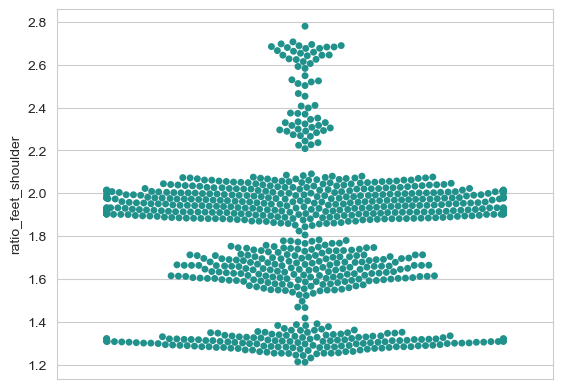

In [16]:
# Set Theme:
sns.set_style('whitegrid')

# Creating Strip plot for day-wise revenue:
sns.swarmplot(y="ratio_feet_shoulder", data=df, palette="viridis")

<AxesSubplot:xlabel='stage', ylabel='ratio_knee_feet'>

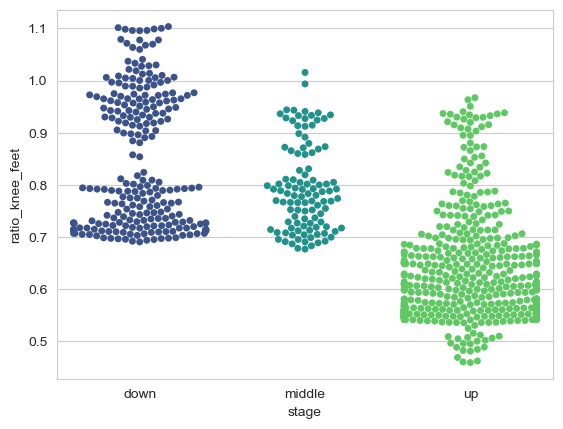

In [20]:
# Set Theme:
sns.set_style('whitegrid')

# Creating Strip plot for day-wise revenue:
sns.swarmplot(x='stage', y="ratio_knee_feet", data=df, palette="viridis")